In [2]:
%load_ext autoreload
%autoreload 2

# PYIN algorithm

## Phase 0: High-pass IRR filter
Preprocess the input audio signal.

The IRR filter lowers the intensity of low frequency noise. We only lower the intensity, not remove completely, to retain harmonic information / contours which may be contained within the lower registers. By doing so, we hope to lower the impact of noisy background inputs on autocorrelation based pitch detection, especially for pitched instruments (from McLeod thesis).

Questions:
- How is intensity defined?
- Also for high frequency?

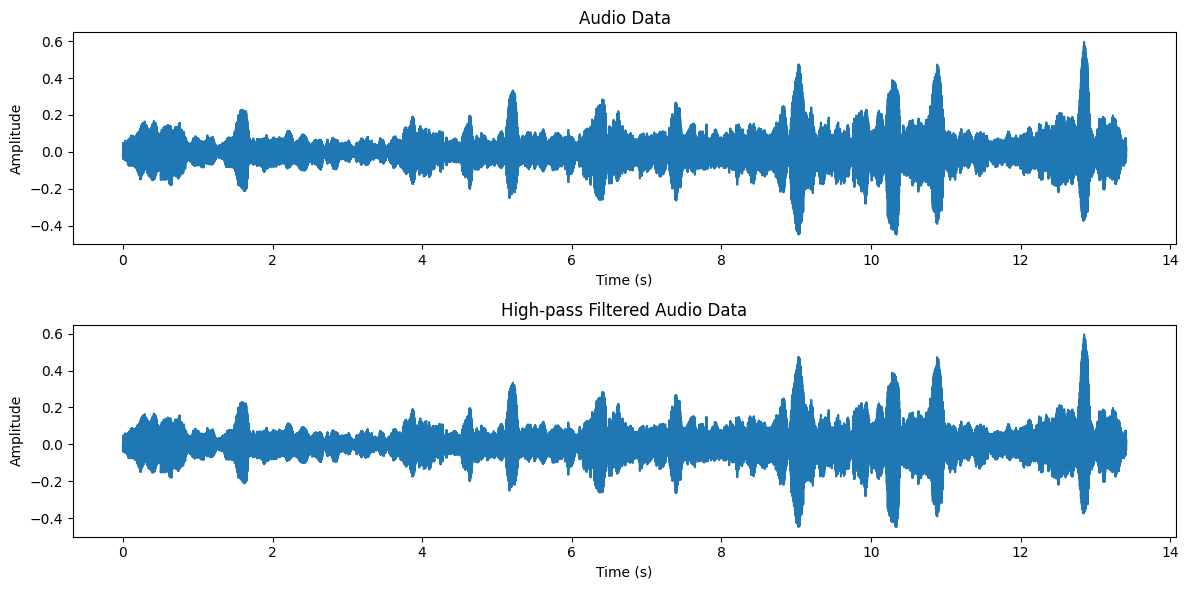

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import essentia.standard as es

import sys
sys.path.append('..')
from app.modules.pitch.pda.Yin import Yin
from app.modules.pitch.pda.Filter import Filter

AUDIO_FILEPATH = 'data/audio_files/user_fugue2.mp3'
MIN_VIOLIN_FREQ = 196.0

# Create a figure and axes
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

SAMPLE_RATE = 44100
original_audio = es.MonoLoader(filename=AUDIO_FILEPATH, sampleRate=SAMPLE_RATE)()
irr_filtered_audio = Filter.high_pass_irr_filter(original_audio, SAMPLE_RATE)

# Plot the audio data
times = np.arange(len(original_audio)) / SAMPLE_RATE
axs[0].plot(times, original_audio)
axs[0].set_title('Audio Data')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')

# Plot the high-pass filtered audio data
times = np.arange(len(irr_filtered_audio)) / SAMPLE_RATE
axs[1].plot(times, irr_filtered_audio)
axs[1].set_title('High-pass Filtered Audio Data')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Amplitude')

fig.tight_layout()
plt.show()

### Playback both filtered and non-filtered audio
You can hear a slight difference, IRR filtered is a little more pointed in sound, less resonance effects.

In [5]:
# Playback both types of audio
from app.modules.audio.AudioData import AudioData
from app.modules.audio.AudioPlayer import AudioPlayer

audio_data = AudioData()
audio_data.write_data(original_audio)

irr_audio_data = AudioData()
irr_audio_data.write_data(irr_filtered_audio)

audio_player = AudioPlayer()
audio_player.load_audio_data(audio_data)
audio_player.play()

# irr_audio_player = AudioPlayer()
# irr_audio_player.load_audio_data(irr_audio_data)
# irr_audio_player.play()

## Phase 1: YIN CMNDF
Basic idea: Find fundamental frequency for a given frame of audio data by comparing how different the original signal is to a signal shifted over by some lag. The amount of lag it shifts over which minimizes this difference is the fundamental period.

### Steps
1. Fast computation of autocorrelation with FFT (wiener khinchin theorem)
    - also returns a power spectrum - mean squared amplitude at each frequency line, no phase information

2. Use the autocorrelation $r_t$ to compute a difference function $d_t$ using the following equality
$$d_t(\tau)=r_t(0)+r_{t+\tau}(0)-2r_t(\tau)$$

3. and normalize each $d_t(\tau)$ value for all lags
based on the cumulative mean of all differences leading up to that point
    - since first lag $d_t(\tau=0)$ always $=1$, 
    - it biases the beginning lags which would otherwise have a very small difference until the number of $\tau$ samples can make up for the 1
    - also avoids "strong resonances at first formant"

Computing pitches with tau_max = 225


/Users/sarah/Desktop/shasha/MIDI-templater/midi-venv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/sarah/Desktop/shasha/MIDI-templater/midi-venv/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


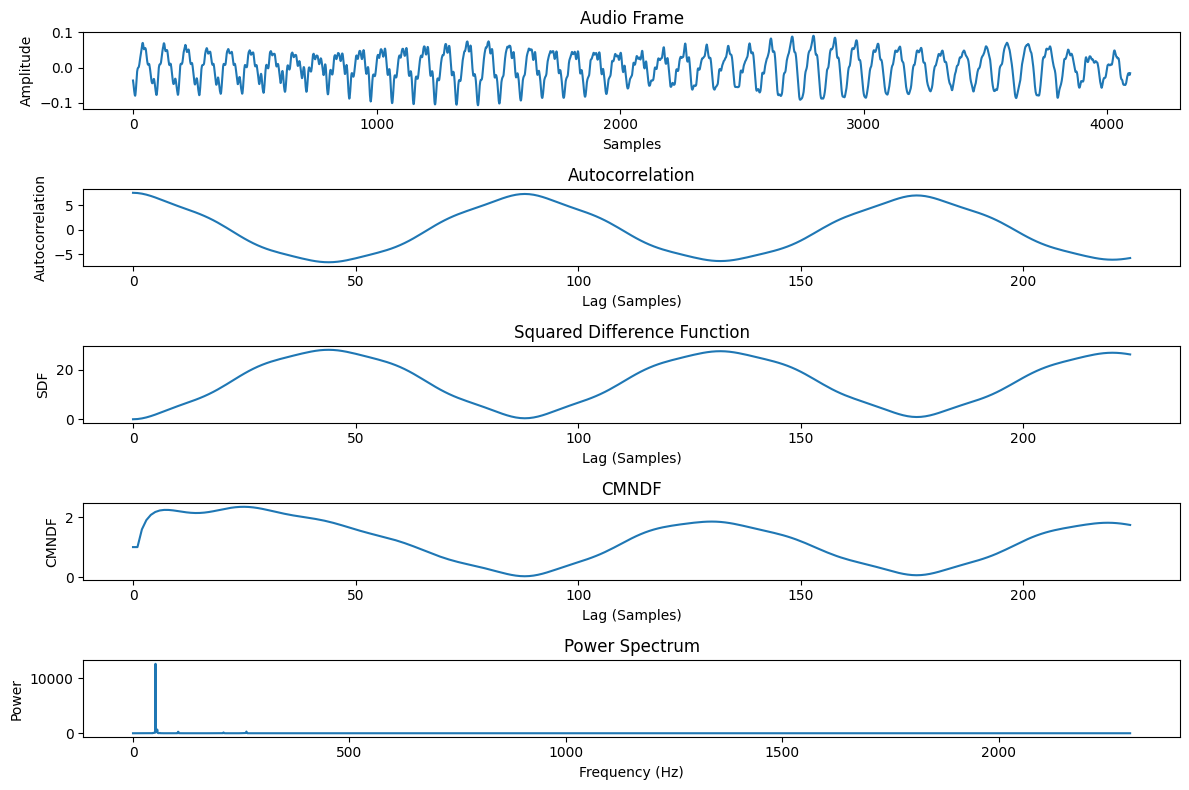

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import sys
sys.path.append('..')

# from app.modules.pitch.Yin.PYin import PYin
from app.modules.pitch.pda.Yin import Yin

AUDIO_FILEPATH = 'data/audio_files/user_fugue2.mp3'
MIN_VIOLIN_FREQ = 196.0

audio_data, sr = librosa.load(AUDIO_FILEPATH, sr=None)
frame_size = 2048*2
audio_frame = audio_data[frame_size*20:frame_size*21]
tau_max = int(sr/MIN_VIOLIN_FREQ) # Ensue max lag is big enough to detect lowest f0 (largest period) of the violin
print(f"Computing pitches with tau_max = {tau_max}")

# Call the autocorrelation function
autocorr, power_spec = Yin.autocorrelation_fft(audio_frame, tau_max)
sdf, power_spec = Yin.difference_function(audio_frame, tau_max)
# snac, power_spec = snac_fct(audio_frame, tau_max)
cmndf_res, power_spec = Yin.cmndf(audio_frame, tau_max)

# Create a figure and axes
fig, axs = plt.subplots(5, 1, figsize=(12, 8)) 

# Plot the audio frame
axs[0].plot(audio_frame)
axs[0].set_title('Audio Frame')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')

# Plot the autocorrelation result
axs[1].plot(autocorr)
axs[1].set_title('Autocorrelation')
axs[1].set_xlabel('Lag (Samples)')
axs[1].set_ylabel('Autocorrelation')

# Plot the squared difference function
axs[2].plot(sdf)
axs[2].set_title('Squared Difference Function')
axs[2].set_xlabel('Lag (Samples)')
axs[2].set_ylabel('SDF')

# Plot the SNAC (SDF alternative used in McLeod's thesis)
# axs[3].plot(snac)
# axs[3].set_title('SNAC')
# axs[3].set_xlabel('Lag (Samples)')
# axs[3].set_ylabel('SNAC')

# Plot the CMNDF
axs[3].plot(cmndf_res)
axs[3].set_title('CMNDF')
axs[3].set_xlabel('Lag (Samples)')
axs[3].set_ylabel('CMNDF')

# Plot the power spectrum
axs[4].plot(power_spec)
axs[4].set_title('Power Spectrum')
axs[4].set_xlabel('Frequency (Hz)')
axs[4].set_ylabel('Power')

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()

Computing pitches with tau_max = 225


/Users/sarah/Desktop/shasha/MIDI-templater/midi-venv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/sarah/Desktop/shasha/MIDI-templater/midi-venv/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 225.0)

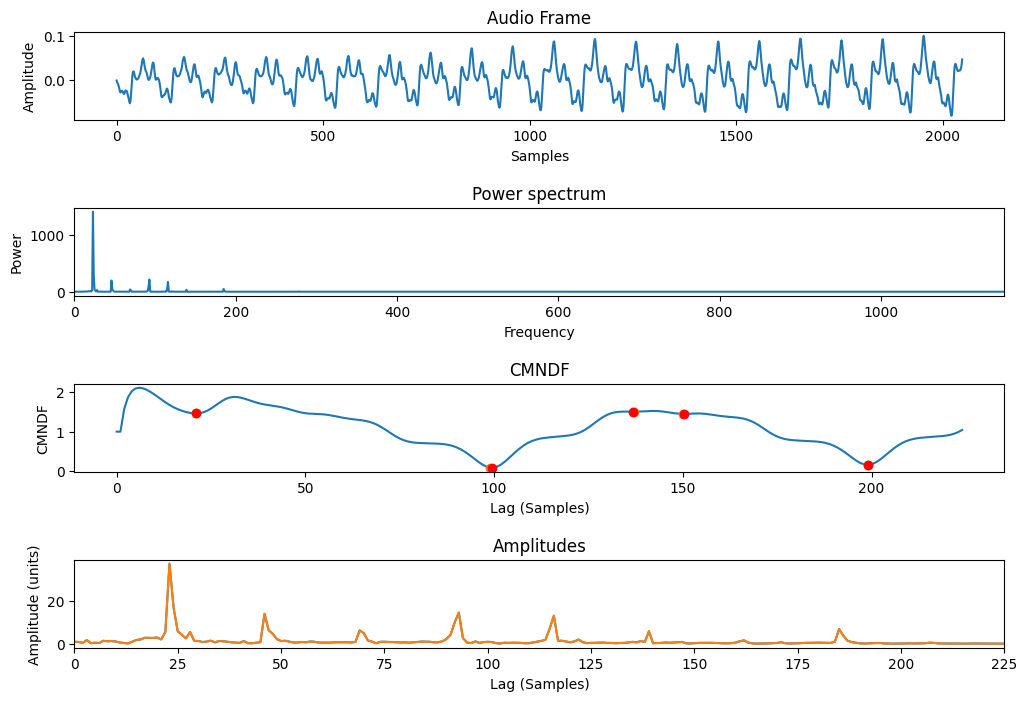

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import sys
import scipy.signal

from app.modules.pitch.pda.PYin import PYin
from app.modules.pitch.pda.Yin import Yin
from app.config import AppConfig


AUDIO_FILEPATH = '../../app/resources/audio/user_fugue2.mp3'
MIN_VIOLIN_FREQ = 196.0

audio_data, sr = librosa.load(AUDIO_FILEPATH, sr=AppConfig.SAMPLE_RATE)
FRAME_SIZE = AppConfig.FRAME_SIZE

# Find the frame for a particular start time
# start_time = 0.36
start_time = 5
start_index = int(AppConfig.SAMPLE_RATE * start_time)
end_index = int(start_index + FRAME_SIZE)

audio_frame = audio_data[start_index:end_index]
tau_max = int(AppConfig.SAMPLE_RATE/MIN_VIOLIN_FREQ) # Window size big enough to detect lowest f0 (largest period) of the violin
print(f"Computing pitches with tau_max = {tau_max}")

# Call the autocorrelation functiond
cmndf_frame, power_spec, amplitudes = Yin.cmndf(audio_frame, tau_max)

base_trough_indices = scipy.signal.argrelmin(cmndf_frame, order=1)[0]
troughs = [Yin.parabolic_interpolation(cmndf_frame, x) for x in base_trough_indices]

# Create a figure and axes
fig, axs = plt.subplots(4, 1, figsize=(12, 8)) 
plt.subplots_adjust(hspace=1)  # Increase the vertical space between plots

# Plot the audio frame
axs[0].plot(audio_frame)
axs[0].set_title('Audio Frame')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')

# Plot the power spectrum
axs[1].plot(power_spec)  
axs[1].set_title('Power spectrum')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Power')
axs[1].set_xlim(0, min(power_spec.size, 5000))

# Plot the CMNDF and parabolic interpolated troughs
axs[2].plot(cmndf_frame)
axs[2].set_title('CMNDF')
axs[2].set_xlabel('Lag (Samples)')
axs[2].set_ylabel('CMNDF')
axs[2].plot(base_trough_indices, cmndf_frame[base_trough_indices], 'o')
for trough in troughs:
    axs[2].plot(trough[0], trough[1], 'or')

# Plot the amplitudes
axs[3].plot(amplitudes)
axs[3].set_title('Amplitudes')
axs[3].set_xlabel('Lag (Samples)')
axs[3].set_ylabel('Amplitude (units)')
axs[3].plot(amplitudes)
axs[3].set_xlim(0, tau_max)

# axs[1].plot(440, 100000, 'o')

In [105]:
# Playback the frame
from app.modules.audio.AudioData import AudioData
from app.modules.audio.AudioPlayer import AudioPlayer

audio_frame_data = AudioData()
audio_frame_data.write_data(audio_frame)

audio_player = AudioPlayer()
audio_player.load_audio_data(audio_frame_data)
audio_player.play()

## Phase 2: Probabalistic Thresholding
Based on modeling all possible thresholds for peak picking as a beta distribution centered around some mean (ex: 0.3)

Mean 0.3 has alpha: 6.0, beta: 14.0


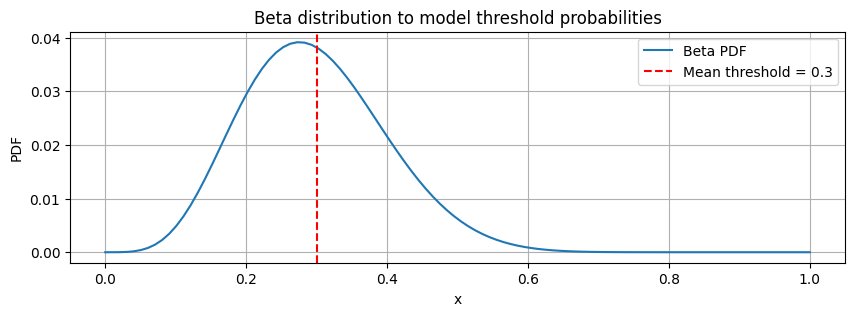

In [96]:
# Define the beta distribution with a total mass of 1
def calculate_alpha_beta(mean_threshold, total=20):
    """
    Calculate alpha and beta for a beta distribution given a desired mean and a total sum of alpha and beta.
    """
    alpha = mean_threshold * total
    beta = total - alpha
    return alpha, beta

N_THRESHOLDS = 100
thresholds = np.linspace(0, 1, N_THRESHOLDS) # add one because we create using np.diff of a cdf
cdf_thresholds = np.linspace(0, 1, N_THRESHOLDS + 1)

# Create beta distribution centered around the desired mean threshold
MEAN_THRESHOLD = 0.3
alpha, beta = PYin.calculate_alpha_beta(MEAN_THRESHOLD, total=20)
print(f"Mean {MEAN_THRESHOLD} has alpha: {alpha}, beta: {beta}")
beta_cdf = scipy.stats.beta.cdf(x=cdf_thresholds, a=alpha, b=beta) # How are alpha and beta calculated?
beta_pdf = np.diff(beta_cdf) # where we know the total mass = 1

# Plot the beta distribution and the mean threshold
plt.figure(figsize=(10, 3))
# plt.plot(beta_thresholds, beta_cdf, label=f'Beta CDF (mean={MEAN_THRESHOLD}, alpha={alpha:.2f}, beta={beta:.2f})')
plt.plot(thresholds, beta_pdf, label='Beta PDF')
plt.axvline(x=MEAN_THRESHOLD, color='red', linestyle='--', label=f'Mean threshold = {MEAN_THRESHOLD}')

plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Beta distribution to model threshold probabilities')
plt.legend()

plt.grid(True)
plt.show()

### Confused but can blackbox: Boltzmann distribution?
Still confused why a Boltzmann distribution is used in the computation of these probabilities. 

1. `trough_threshold_matrix` - We create a matrix of all troughs at all thresholds and whether they are below the threshold (True) or not (False).
2. `trough_ranks` - Count number of valid troughs for each threshold (add up all the Trues we've seen so far in each column)
3. `n_troughs` - The total count of valid troughs for each threshold (1D version of trough_ranks)

I am unsure how n_trouhgs and trough_ranks come together in the boltzmann.pmf function to create the trough prior probabilities.
But we then for each threshold, we multiply elementwise the prior prob + beta distribution for all troughs detected at that threshold.

### Confused and cannot blackbox: Voicing?
Also accounting for those troughs that are 'unvoiced' by finding the minimum probability trough after accounting for beta probabilities, ...?

Shape of the trough_threshold_matrix: (12, 99)


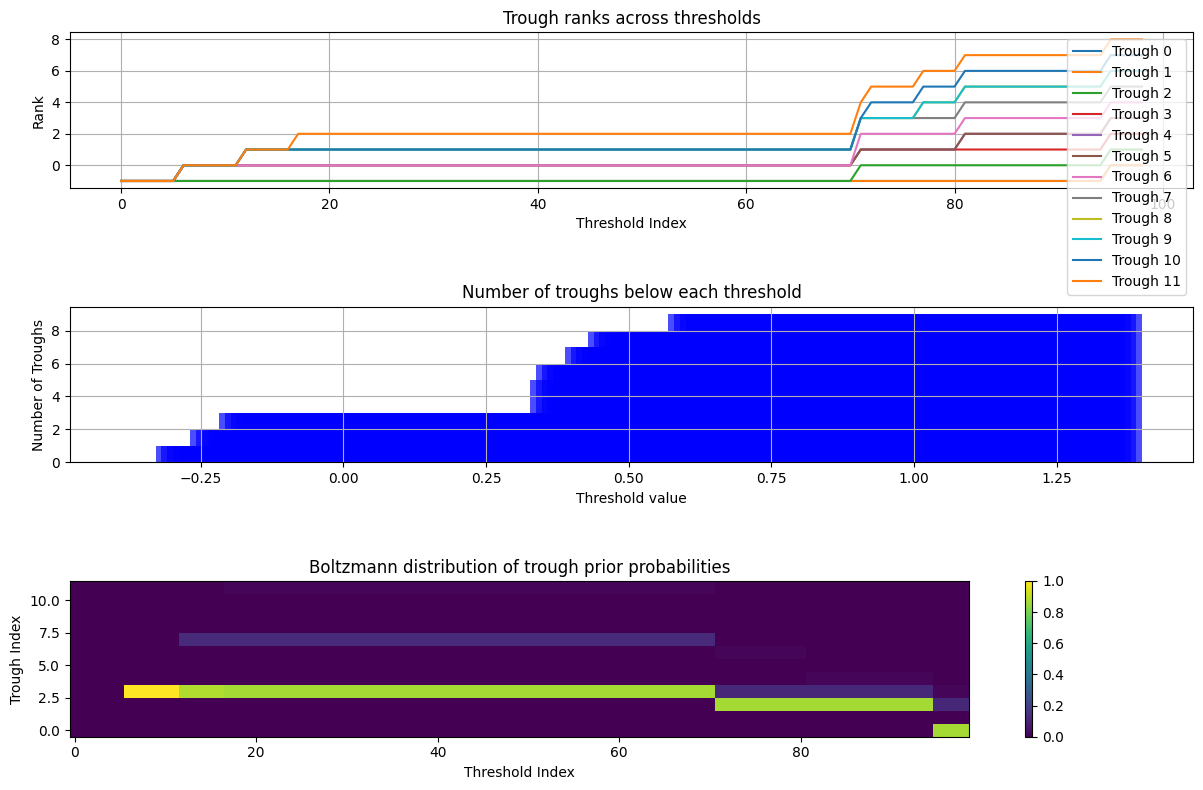

In [26]:
import matplotlib.pyplot as plt

trough_x_vals = np.array([trough[0] for trough in troughs])
trough_y_vals = np.array([trough[1] for trough in troughs])

N_THRESHOLDS = 100
thresholds = np.linspace(0, 1, N_THRESHOLDS)

# Boolean matrix indicating if the trough height is below the threshold
# for each pair-wise combination of trough y values and thresholds
#
# The shape of the resulting array is (n_troughs, n_thresholds), ex: (12, 100)
# rows = trough_heights, cols = threshold_vals
trough_threshold_matrix = np.less.outer(trough_y_vals, thresholds[1:])
print(f"Shape of the trough_threshold_matrix: {trough_threshold_matrix.shape}")

# Define prior over the troughs
# For each trough, replace the true/false with a count of how many true's it's seen so far
trough_ranks = np.cumsum(trough_threshold_matrix, axis=0)-1 # the index of the trough in the sorted list
n_troughs = np.count_nonzero(trough_threshold_matrix, axis=0)

# Define a Boltzmann distribution over the trough ranks
BOLTZMANN_PARAM = 2.0
trough_prior = scipy.stats.boltzmann.pmf(trough_ranks, BOLTZMANN_PARAM, n_troughs)
trough_prior[~trough_threshold_matrix] = 0

# Create a figure with subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 8))

# Plot the ranks of each trough across thresholds in the first subplot
for i in range(trough_ranks.shape[0]):
    axs[0].plot(trough_ranks[i], label=f'Trough {i}')

axs[0].set_xlabel('Threshold Index')
axs[0].set_ylabel('Rank')
axs[0].set_title('Trough ranks across thresholds')
axs[0].legend()
axs[0].grid(True)

# Plot the histogram of the number of troughs per threshold in the second subplot
axs[1].bar(thresholds[1:], n_troughs, color='b', alpha=0.7)
axs[1].set_xlabel('Threshold value')
axs[1].set_ylabel('Number of Troughs')
axs[1].set_title('Number of troughs below each threshold')
axs[1].grid(True)

# Plot the computed trough prior probabilities
# axs[2].plot(trough_prior)
# axs[2].set_title('Boltzmann distribution of trough prior probabilities')
# axs[2].set_xlabel('Trough Index')
# axs[2].set_ylabel('Prior Probability')
# axs[2].grid(True)

cax = axs[2].imshow(trough_prior, aspect='auto', origin='lower', cmap='viridis')
axs[2].set_title('Boltzmann distribution of trough prior probabilities')
axs[2].set_xlabel('Threshold Index')
axs[2].set_ylabel('Trough Index')
fig.colorbar(cax, ax=axs[2], orientation='vertical')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### View results: Probablistic thresholding

Seem to get good results aligned with what we expect!

In [14]:
import sys
sys.path.append('..')
from app.modules.pitch.pda.PYin import PYin
from app.modules.audio.AudioData import AudioData
import essentia.standard as es

AUDIO_FILEPATH = 'data/audio_files/user_fugue2.mp3'
MIN_VIOLIN_FREQ = 196.0
SAMPLE_RATE = 44100

audio_data = AudioData()
audio_data.load_data(AUDIO_FILEPATH)

pitches, most_likely_pitches = PYin.pyin(audio_data)
# pitches, most_likely_pitches, voiced_probs, emission_matrix, transition_matrix = PYin.pyin(audio_data)

Starting pYIN algorithm...
Processing frame 4604/4604
Done!


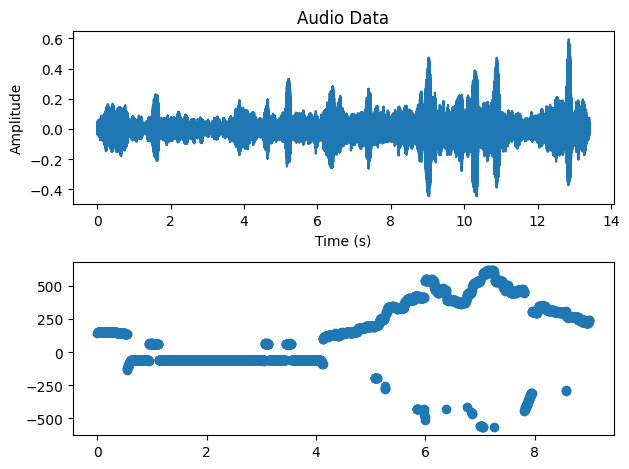

In [74]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Trying essentia pyin
es_pitches, voiced_probs = es.PitchYinProbabilistic()(audio_data.data)


fig, axs = plt.subplots(2, 1)

# Plot the audio data
times = np.arange(len(audio_data.data)) / SAMPLE_RATE
axs[0].plot(times, audio_data.data)
axs[0].set_title('Audio Data')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')

# Plot detected pitches
# final_xs = np.arange(len(pitch_bins))
pitch_times = np.arange(len(es_pitches)) / 256
axs[1].plot(pitch_times, es_pitches, 'o', label='Pitch')

# Display the plot
plt.tight_layout()
plt.show()

## Onset Detection

Idea: Filter out resonances

In [11]:
from app.modules.pitch.Onsets import Onsets

os = Onsets()
onsets = os.detect_onsets(audio_data)
note_df = os.detect_pitch_changes(most_likely_pitches, window_size=21, threshold=0.4)

onsets

Detecting onsets...
Onset detection complete.
Segmenting notes with window_size=21 and threshold=0.4...


array([1.16099771e-02, 2.32199550e-01, 4.64399099e-01, 6.61768734e-01,
       8.93968225e-01, 1.09133792e+00, 1.30031741e+00, 1.48607707e+00,
       1.67183673e+00, 1.92725623e+00, 2.08979583e+00, 2.29877543e+00,
       2.49614501e+00, 2.69351482e+00, 2.87927437e+00, 3.09986401e+00,
       3.27401352e+00, 3.45977330e+00, 3.70358276e+00, 3.91256237e+00,
       4.12154198e+00, 4.26086187e+00, 4.48145103e+00, 4.64399099e+00,
       4.91102028e+00, 5.08517027e+00, 5.27092981e+00, 5.50312948e+00,
       5.70049906e+00, 5.85142851e+00, 6.10684824e+00, 6.23455763e+00,
       6.46675730e+00, 6.59446716e+00, 6.90793657e+00, 7.05886602e+00,
       7.29106569e+00, 7.69741488e+00, 7.87156439e+00, 8.04571438e+00,
       8.11537457e+00, 8.71909332e+00, 8.89324284e+00, 9.10222244e+00,
       9.32281208e+00, 9.47374153e+00, 9.76399136e+00, 9.88009071e+00,
       1.02051697e+01, 1.06115189e+01, 1.08088884e+01, 1.11920185e+01,
       1.13777781e+01, 1.17492971e+01, 1.19350567e+01, 1.21556463e+01,
      

Computing pitches with tau_max = 225


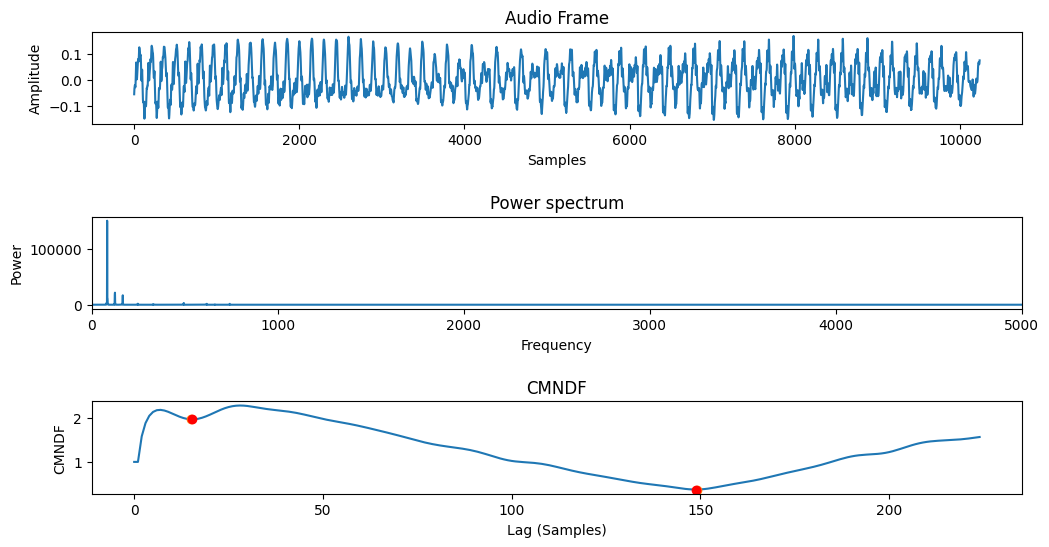

In [5]:
import sys
sys.path.append('..')
from app.modules.pitch.pda.PYin import PYin
from app.modules.pitch.pda.Yin import Yin
from app.modules.audio.AudioData import AudioData
import essentia.standard as es
import numpy as np
import matplotlib.pyplot as plt
import scipy

UDIO_FILEPATH = '../../app/resources/audio/user_fugue2.mp3'
MIN_VIOLIN_FREQ = 196.0
SAMPLE_RATE = 44100

audio_data = AudioData()
audio_data.load_data(AUDIO_FILEPATH)

a_start = 0.232199550
e_end = 0.464399099

a_start_index = int(a_start * SAMPLE_RATE)
e_end_index = int(e_end * SAMPLE_RATE)

audio_frame = audio_data.data[a_start_index:e_end_index]

tau_max = int(44100/MIN_VIOLIN_FREQ) # Window size big enough to detect lowest f0 (largest period) of the violin
print(f"Computing pitches with tau_max = {tau_max}")

# Call the autocorrelation functiond
cmndf_frame, power_spec, amplitudes = Yin.cmndf(audio_frame, tau_max)

base_trough_indices = scipy.signal.argrelmin(cmndf_frame, order=1)[0]
troughs = [Yin.parabolic_interpolation(cmndf_frame, x) for x in base_trough_indices]

# Create a figure and axes
fig, axs = plt.subplots(3, 1, figsize=(12, 6)) 
plt.subplots_adjust(hspace=1)  # Increase the vertical space between plots

# Plot the audio frame
axs[0].plot(audio_frame)
axs[0].set_title('Audio Frame')
axs[0].set_xlabel('Samples')
axs[0].set_ylabel('Amplitude')

# Plot the power spectrum
axs[1].plot(power_spec)  
axs[1].set_title('Power spectrum')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Power')
axs[1].set_xlim(0, min(power_spec.size, 5000))

# Plot the CMNDF and parabolic interpolated troughs
axs[2].plot(cmndf_frame)
axs[2].set_title('CMNDF')
axs[2].set_xlabel('Lag (Samples)')
axs[2].set_ylabel('CMNDF')
axs[2].plot(base_trough_indices, cmndf_frame[base_trough_indices], 'o')
for trough in troughs:
    axs[2].plot(trough[0], trough[1], 'or')

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, irfft, fftfreq

# Constants
SAMPLE_RATE = 44100

audio_data = AudioData()
audio_data.load_data(AUDIO_FILEPATH)

a_start = 0.232199550
e_end = 0.464399099

a_start_index = int(a_start * SAMPLE_RATE)
e_end_index = int(e_end * SAMPLE_RATE)

audio_frame = audio_data.data[a_start_index:e_end_index]

# Step 1: Transform the audio_frame to the frequency domain using rfft
audio_spectrum = rfft(audio_frame)
freqs = fftfreq(audio_frame.size, d=1/SAMPLE_RATE)

# Step 2: Compute the power spectrum (magnitude squared of the spectrum)
power_spectrum = np.abs(audio_spectrum)**2

# Step 3: Find the most salient frequency (the one with the highest power)
most_salient_idx = np.argmax(power_spectrum)
# Find all local maxima
all_indices = scipy.signal.argrelmax(power_spectrum, order=1)[0]
print(f"Indices of all local maxima: {all_indices}")
# most_salient_frequency = freqs[most_salient_idx]
# print(f"Most salient frequency: {most_salient_frequency} Hz")

# # Step 4: Remove the most salient frequency by setting its amplitude to zero
# audio_spectrum[most_salient_idx] = 0

# # Step 5: Transform back to the time domain using irfft
# filtered_audio_frame = irfft(audio_spectrum)

# # Call the autocorrelation functiond
# cmndf_frame, power_spec = Yin.cmndf(filtered_audio_frame, tau_max)

# base_trough_indices = scipy.signal.argrelmin(cmndf_frame, order=1)[0]
# troughs = [Yin.parabolic_interpolation(cmndf_frame, x) for x in base_trough_indices]

# # Create a figure and axes
# fig, axs = plt.subplots(3, 1, figsize=(12, 6)) 
# plt.subplots_adjust(hspace=1)  # Increase the vertical space between plots

# # Plot the audio frame
# axs[0].plot(filtered_audio_frame)
# axs[0].set_title('Filtered Audio Frame')
# axs[0].set_xlabel('Samples')
# axs[0].set_ylabel('Amplitude')

# # Plot the power spectrum
# axs[1].plot(power_spec)  
# axs[1].set_title('Power spectrum')
# axs[1].set_xlabel('Frequency')
# axs[1].set_ylabel('Power')
# axs[1].set_xlim(0, min(power_spec.size, 5000))

# # Plot the CMNDF and parabolic interpolated troughs
# axs[2].plot(cmndf_frame)
# axs[2].set_title('CMNDF')
# axs[2].set_xlabel('Lag (Samples)')
# axs[2].set_ylabel('CMNDF')
# axs[2].plot(base_trough_indices, cmndf_frame[base_trough_indices], 'o')
# for trough in troughs:
#     axs[2].plot(trough[0], trough[1], 'or')


Indices of all local maxima: [   1    7   10 ... 5106 5109 5113]


In [18]:
# Insert filtered back into audio_data and see what changes
audio_data.data[a_start_index:e_end_index] = filtered_audio_frame

In [19]:
pitches, most_likely_pitches = PYin.pyin(audio_data)

Starting pYIN algorithm...
Processing frame 4604/4604
Done!


### Onset tests: Librosa (X)

Librosa tends to detect too-many onsets.

In [40]:
import librosa

librosa_onsets = librosa.onset.onset_detect(y=audio_data.data, sr=SAMPLE_RATE, units='time')

o_env = librosa.onset.onset_strength(y=audio_data.data, sr=SAMPLE_RATE)
times = librosa.times_like(o_env, sr=SAMPLE_RATE)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=SAMPLE_RATE)
# librosa_onsets
# onset_frames
onset_times = librosa.frames_to_time(onset_frames, sr=SAMPLE_RATE)
# onset_times

## HMM tests: Viterbi Algorithm intuition
Backpointer matrix

@@@

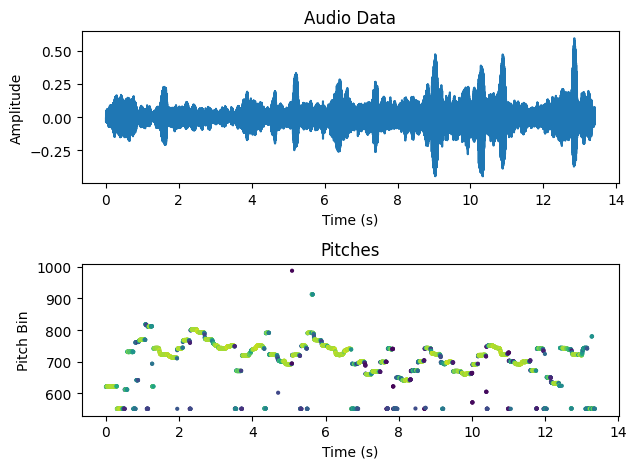

In [66]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Create a figure and axes
fig, axs = plt.subplots(2, 1)

# Plot the audio data
times = np.arange(len(audio_data.data)) / SAMPLE_RATE
axs[0].plot(times, audio_data.data)
axs[0].set_title('Audio Data')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Amplitude')

# Plot detected pitches
times = [pitch.time for pitch in most_likely_pitches]
frequencies = [pitch.frequency for pitch in most_likely_pitches]
probabilities = [pitch.probability for pitch in most_likely_pitches]
pitch_bins = [pitch.pitch_bin for pitch in most_likely_pitches]
colors = [cm.viridis(prob) for prob in probabilities]

# final_xs = np.arange(len(pitch_bins))
axs[1].scatter(times, pitch_bins, color=colors, s=4)
axs[1].set_title('Pitches')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Pitch Bin')

# Display the plot
plt.tight_layout()
plt.show()

In [20]:
# View the pitch estimates in the app
import sys
sys.path.append('..')

from app.ui.plots.PitchPlot import RunPitchPlot
from app.modules.midi.MidiData import MidiData
from PyQt6.QtWidgets import QApplication
from PyQt6.QtCore import QCoreApplication


if __name__ == '__main__':
    if not QCoreApplication.instance():
        app = QApplication(sys.argv)
    else:
        app = QCoreApplication.instance()

    MIDI_FILEPATH = '../app/resources/midi/fugue.mid'
    midi_data = MidiData(MIDI_FILEPATH)

    pitchplot = RunPitchPlot(
        app, midi_data=midi_data, pitches=pitches, onsets=onsets, note_df=note_df
    )

Plotting pitches...
Done!


qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=364.563,243.544 gbl=364.563,243.544 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-364.563,-243.544 last=-364.563,-243.544 Δ 364.563,243.544) : no target window
qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=437.54,371.231 gbl=437.54,371.231 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-437.54,-371.231 last=-437.54,-371.231 Δ 437.54,371.231) : no target window
qt.pointer.dispatch: skipping QEventPoint(id=2 ts=0 pos=0,0 scn=371.175,519.48 gbl=371.175,519.48 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-371.175,-519.48 last=-371.175,-519.48 Δ 371.175,519.48) : no target window
qt.pointer.dispatch: skipping QEventPoint(id=2 ts=0 pos=0,0 scn=652.771,583.922 gbl=652.771,583.922 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-652.771,-583.922 last=-652.771,-583.922 Δ 652.771,583.922) : no target window
qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=360.088,340.171 gbl=360.088,340.171 Released ellipse=(1x1 ∡ 0) vel

## Phase 3: HMM-based pitch tracking
Using the viterbi algorithm to decode the hidden state (the true pitch sequence) for the audio.

### Emission matrix
Emission matrix stores the probabilities of going from a hidden state to every possible choice of observation.

In PYIN, we use the computed frame-wise set of pitches + probabilities to define the emission(observation) probabilities for the HMM. 

### Transition matrix
Transitions are defined as 

In [88]:
from app.modules.pitch.pda.hmm.Viterbi import viterbi2
from app.modules.pitch.Pitch import Pitch, PitchConfig

# Run the Viterbi algorithm
state_sequence, max_prob = viterbi2(emission_matrix, transition_matrix)

# Recreate the pitch sequence from the state sequence
final_pitches = []
pitch_config = PitchConfig( # Defines resolution of pitch bins
    bins_per_semitone=10, tuning=440.0, fmin=196, fmax=3000
)
for i, state in enumerate(state_sequence):
    final_pitches.append(Pitch.bin_index_to_midi(state, pitch_config))


In [ ]:
for i, state in enumerate(state_sequence):
    print(f"Frame {i}: State {state}")

In [3]:
# Viterbi algorithm: Example viterbi_matrix, backpointer_matrix
import numpy as np
import sys
sys.path.append('..')
from app.modules.pitch.pda.hmm.Viterbi import viterbi

# Test Case for Viterbi Algorithm

# Define the states
states = np.array([0, 1])  # Let's assume 0 = 'Healthy', 1 = 'Fever'

# Define the observations (observation sequence as indices)
observations = np.array([2, 1, 2, 0, 0])  # Let's assume 0 = 'normal', 1 = 'cold', 2 = 'dizzy'

# Define the initial state probabilities
initial_matrix = np.array([0.6, 0.4])  # P(Healthy) = 0.6, P(Fever) = 0.4

# Define the transition probabilities (from state i to state j)
transition_matrix = np.array([
    [0.7, 0.3],  # Healthy -> [Healthy, Fever]
    [0.4, 0.6]   # Fever -> [Healthy, Fever]
])

# Define the emission probabilities (state -> observation)
emission_matrix = np.array([
    [0.5, 0.4, 0.1],  # Healthy -> [normal, cold, dizzy]
    [0.1, 0.3, 0.6]   # Fever -> [normal, cold, dizzy]
])

# Run the Viterbi algorithm
state_sequence, max_probability, viterbi_matrix, backpointer_matrix = viterbi(
    observations, states, initial_matrix, transition_matrix, emission_matrix
)

# np.set_printoptions()
print(f"Most likely state sequence: {state_sequence}")
print(f"Max probability of the sequence: {max_probability}")
print(f"Viterbi matrix:\n{viterbi_matrix}")
print(f"Backpointer matrix:\n{backpointer_matrix}")


Most likely state sequence: [1 1 1 0 0]
Max probability of the sequence: 0.0010886399999999997
Viterbi matrix:
[[6.00000e-02 3.84000e-02 2.68800e-03 3.11040e-03 1.08864e-03]
 [2.40000e-01 4.32000e-02 1.55520e-02 9.33120e-04 9.33120e-05]]
Backpointer matrix:
[[0. 1. 0. 1. 0.]
 [0. 1. 1. 1. 0.]]


In [4]:
import numpy as np

# Simulated observation probabilities for 3 frames and 5 pitch bins
observation_probs = np.array([
    [0.2, 0.1, 0.05],  # Frame 1 probabilities for 5 pitch bins
    [0.3, 0.2, 0.15],
    [0.1, 0.05, 0.1],
    [0.25, 0.15, 0.2],
    [0.15, 0.5, 0.25]
])

print("Observation probabilities:\n", observation_probs)

# Summing probabilities across pitch bins (columns)
voiced_prob = np.sum(observation_probs, axis=0)
print("\nSummed voiced probabilities (before clipping):\n", voiced_prob)

# Ensure the voiced probability is between 0 and 1
voiced_prob_clipped = np.clip(voiced_prob, 0, 1)
print("\nVoiced probabilities (after clipping):\n", voiced_prob_clipped)



Observation probabilities:
 [[0.2  0.1  0.05]
 [0.3  0.2  0.15]
 [0.1  0.05 0.1 ]
 [0.25 0.15 0.2 ]
 [0.15 0.5  0.25]]

Summed voiced probabilities (before clipping):
 [1.   1.   0.75]

Voiced probabilities (after clipping):
 [1.   1.   0.75]


In [24]:
# Create dictionary of score lines for the PitchPlot
import json

pitch_to_midi = {
    'D2': 38,
    'E2': 40,
    'F2': 41,
    'G2': 43,
    'A2': 45,
    'B2': 47,
    'C3': 48,
    'D3': 50,
    'E3': 52,
    'F3': 53,
    'G3': 55,
    'A3': 57,
    'B3': 59,
    'C4': 60,
    'D4': 62,
    'E4': 64,
    'F4': 65,
    'G4': 67,
    'A4': 69,
    'B4': 71,
    'C5': 72,
    'D5': 74,
    'E5': 76,
    'F5': 77,
    'G5': 79,
    'A5': 81,
    'B5': 83,
    'C6': 84,
    'D6': 86,
    'E6': 88,
    'F6': 89,
    'G6': 91,
    'A6': 93,
    'B6': 95,
    'C7': 96,
    'D7': 98
}

with open('pitch_json.json', 'w') as json_file:
    json.dump(pitch_to_midi, json_file)